### Imports

You may need to run this cell (replacing the path with the location of the repository in your filesystem) in order to ensure that Python can find the imports.

In [1]:
import sys
sys.path.insert(0, '../src')  # Use relative path and insert at beginning to prioritize local version

We will use numpy to generate the dataset and matplotlib for plotting.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import rcParams

The only SPIDER-specific objects that need to be imported are the Observable, which represents a tensor-valued data field (such as
the scalar pressure $p$ or the vector flow velocity ${\bf u}$) and the SRDataset, which will store all of the attributes 
associated with the present dataset.

In [3]:
from PySPIDER.commons.library import Observable
from PySPIDER.continuous.process_library_terms import SRDataset

### Generating the dataset

To test SPIDER, let's generate a [Taylor-Green vortex](https://en.wikipedia.org/wiki/Taylor%E2%80%93Green_vortex) solution $\{p(x, y, t), {\bf u}(x, y, t)\}$ in two spatial dimensions with a kinematic viscosity $\nu = 0.01$. It should satisfy the Navier-Stokes equation $$\partial_t {\bf u} + ({\bf u} \cdot \nabla) {\bf u} + \nabla p - \nu \nabla^2 {\bf u}  = 0$$ as well as the incompressibility condition $$\nabla \cdot {\bf u} = 0.$$ Let's see which equations SPIDER will find.

In [4]:
Lx = 4; Ly = 4; Lt = 1;
Nx = 256; Ny = Nx; Nt = 128 # analytical
dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;

x = np.arange(0, 4, dx); y = np.arange(0, 4, dy); t = np.arange(0, 1, dt)
xg, yg = np.meshgrid(x, y)
U = 4*np.einsum('i,j,k->ijk', np.sin(4*x), np.cos(4*y), np.exp(-0.64*t))
V = -4*np.einsum('i,j,k->ijk', np.cos(4*x), np.sin(4*y), np.exp(-0.64*t))

P = 4*np.einsum('ij, k->ijk', np.cos(8*xg)+np.cos(8*yg), np.exp(-1.28*t))
u = np.concatenate([U[:, :, :, np.newaxis], V[:, :, :, np.newaxis]], axis=3)

The data are formatted as numpy arrays with axes (x, y, t), followed by optional axes for each component of the observable. For instance, the scalar pressure is represented by P, a 3D array with axes (x, y, t), whereas the vector flow velocity is stored in a 4D with an additional axis corresponding to the component (x or y).

In [5]:
P.shape, u.shape

((256, 256, 128), (256, 256, 128, 2))

The square spatial domain is periodically tiled by rotationally symmetric vortices, which decay exponentially over time:

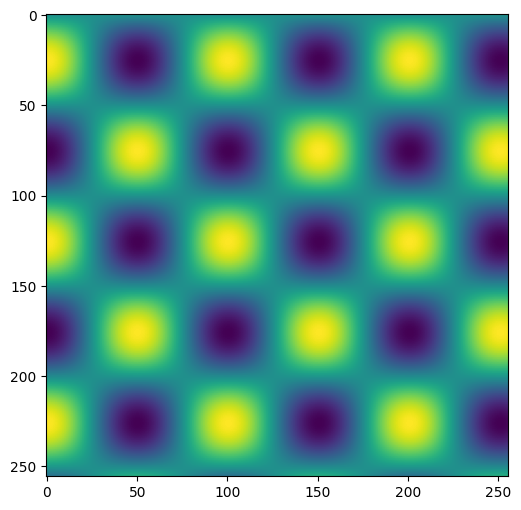

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(U[:, :, 32])

### Defining and evaluating SPIDER objects

Next, let's define Observable objects representing the scalar field $p$ and vector field ${\bf u}$ and create a mapping from the observable names to the numpy data arrays.

In [7]:
pobs = Observable(string='p', rank=0)
uobs = Observable(string='u', rank=1)
observables = [uobs, pobs]
data_dict = {'p': P, 'u': u}

uobs, pobs # the string representation shows where the indices of the tensor can go

(u_{ }, p)

It is also possible to define rank-2 tensor-valued observables. However, we will not use these in the present tutorial.

In [8]:
A = Observable(string='A', rank=2) # second-rank tensor observable with no special properties
A_sym = Observable(string='A', rank=2, can_commute_indices=True) # a symmetric second-rank tensor
# finally, an antisymmetric second-rank tensor
A_antisym = Observable(string='A', rank=2, can_commute_indices=True, antisymmetric=True) 

A # again, we can print out the Observable

A_{ }{ }

Now we can finish setting up the dataset.

In [9]:
world_size = np.array(P.shape) # dimensions of the dataset (in grid points)
dxs = [dx, dy, dt] # grid spacings along each dimension

np.random.seed(1) # set the random seed so the random sample of integration domains is fixed

# initial setup of the dataset object
srd = SRDataset(world_size=world_size, data_dict=data_dict, observables=observables, dxs=dxs, 
                irreps=SRDataset.all_rank2_irreps(), cache_primes=True)


The irreps parameter represents the irreducible representations of the rotational symmetry group $O(n)$ to use for model discovery. Here we use the default value, which constructs separate libraries corresponding to scalar, vector, antisymmetric rank-2, and trace-free symmetric rank-2 equations. (For the rank-2 irreducible representations, the terms and equations that are output implicitly include the projection onto the correct subspace.)

cache_primes=True allows us to cache some of the library evaluation results. To save memory, it is possible to switch this to False, at the cost of a substantial slowdown of library evaluation.

The next step is always to construct the libraries. By default, SPIDER just generates all terms up to a complexity threshold, but we can also ask for additional constraints. Note that the string representation of all symbolic objects uses Einstein notation.

In [10]:
srd.make_libraries(max_complexity=4)
for irrep in srd.irreps:
    print(f"The {irrep} library has {len(srd.libs[irrep].terms)} terms:")
    print(srd.libs[irrep].terms)
    print()

The Rank 0 library has 43 terms:
[p, p · p, p · p · p, p · p · p · p, p · p · ∂t p, p · p · u_α · u_α, p · p · ∂α u_α, p · ∂α p · u_α, p · ∂α² p, p · ∂t p, p · ∂t² p, p · u_α · u_α, p · u_α · ∂t u_α, p · ∂α u_α, p · ∂t ∂α u_α, ∂α p · ∂α p, ∂α p · u_α, ∂α p · ∂t u_α, ∂α² p, ∂t p, ∂t p · ∂t p, ∂t p · u_α · u_α, ∂t p · ∂α u_α, ∂t ∂α p · u_α, ∂t ∂α² p, ∂t² p, ∂t³ p, u_α · u_α, u_α · u_α · u_β · u_β, u_α · u_α · ∂β u_β, u_α · u_β · ∂α u_β, u_α · ∂β² u_α, u_α · ∂α ∂β u_β, u_α · ∂t u_α, u_α · ∂t² u_α, ∂α u_α, ∂α u_β · ∂β u_α, ∂α u_α · ∂β u_β, ∂α u_β · ∂α u_β, ∂α² ∂β u_β, ∂t u_α · ∂t u_α, ∂t ∂α u_α, ∂t² ∂α u_α]

The Rank 1 library has 51 terms:
[p · p · p · u_α, p · p · ∂α p, p · p · u_α, p · p · ∂t u_α, p · ∂α p, p · ∂t p · u_α, p · ∂t ∂α p, p · u_α, p · u_α · u_β · u_β, p · u_α · ∂β u_β, p · u_β · ∂β u_α, p · u_β · ∂α u_β, p · ∂β² u_α, p · ∂α ∂β u_β, p · ∂t u_α, p · ∂t² u_α, ∂α p, ∂α p · ∂t p, ∂β p · u_α · u_β, ∂α p · u_β · u_β, ∂α p · ∂β u_β, ∂β p · ∂α u_β, ∂β p · ∂β u_α, ∂α ∂β p · u_β, ∂β²

Let's illustrate constraining the libraries a bit.

In [11]:
max_observable_counts = {pobs: 1, uobs: 999} # we don't want p to appear in any term more than once, but u is fine 
# let's say we also don't want time derivatives of order higher than 1 or spatial derivatives higher than 2
srd.make_libraries(max_complexity=4, max_observable_counts=max_observable_counts,
                   max_dt=1, max_dx=2) 
# Another parameter you can use is max_observables for max total number of observables in one term

for irrep in srd.irreps:
    print(f"The {irrep} library now has {len(srd.libs[irrep].terms)} terms:")
    print(srd.libs[irrep].terms)
    print()

The Rank 0 library now has 26 terms:
[p, p · u_α · u_α, p · u_α · ∂t u_α, p · ∂α u_α, p · ∂t ∂α u_α, ∂α p · u_α, ∂α p · ∂t u_α, ∂α² p, ∂t p, ∂t p · u_α · u_α, ∂t p · ∂α u_α, ∂t ∂α p · u_α, ∂t ∂α² p, u_α · u_α, u_α · u_α · u_β · u_β, u_α · u_α · ∂β u_β, u_α · u_β · ∂α u_β, u_α · ∂α ∂β u_β, u_α · ∂β² u_α, u_α · ∂t u_α, ∂α u_α, ∂α u_α · ∂β u_β, ∂α u_β · ∂α u_β, ∂α u_β · ∂β u_α, ∂t u_α · ∂t u_α, ∂t ∂α u_α]

The Rank 1 library now has 37 terms:
[p · u_α, p · u_α · u_β · u_β, p · u_α · ∂β u_β, p · u_β · ∂α u_β, p · u_β · ∂β u_α, p · ∂α ∂β u_β, p · ∂β² u_α, p · ∂t u_α, ∂α p, ∂α p · u_β · u_β, ∂β p · u_α · u_β, ∂α p · ∂β u_β, ∂β p · ∂β u_α, ∂β p · ∂α u_β, ∂β² p · u_α, ∂α ∂β p · u_β, ∂t p · u_α, ∂t p · ∂t u_α, ∂t ∂α p, u_α, u_α · u_β · u_β, u_β · u_β · ∂t u_α, u_α · u_β · ∂t u_β, u_α · ∂β u_β, u_β · ∂β u_α, u_β · ∂α u_β, u_α · ∂t ∂β u_β, u_β · ∂t ∂α u_β, u_β · ∂t ∂β u_α, ∂β u_β · ∂t u_α, ∂α u_β · ∂t u_β, ∂β u_α · ∂t u_β, ∂β² u_α, ∂α ∂β u_β, ∂t u_α, ∂t ∂β² u_α, ∂t ∂α ∂β u_β]

The Antisymmetric r

The next step is to construct the integration domains and scalar weight functions. SPIDER will automatically convert the scalar weights into tensor-valued ones when evaluating the non-scalar irreducible representations.

In [12]:
# make 50 domains that are 40x40x20 grid points
dom_width = 40
dom_time = 20
srd.make_domains(ndomains=50, domain_size=[dom_width, dom_width, dom_time], pad=0)
# pad>0 would ensure a distance of pad grid points between the domain and the edge of the dataset

# We can display the corner coordinates of some of these. Note that rerunning this cell will resample the domains!
print(srd.domains[0:5])

# m is the envelope exponent in the weight function (usually doesn't need to be tuned)
# qmax is the max degree of Legendre polynomial to use in the weight functions:
# this lets us construct (qmax+1)^3 independent weight functions per integration domain
srd.make_weights(m=12, qmax=0)

# With the default value, there is only one weight function.
# q indexes the Legendre polynomial, k is the derivative order applied to the weight function, 
# coeff is a constant scaling factor, and dxs is a coordinate rescaling used during integration.
# Don't worry too much about all of the attributes - they are handled automatically.
print(srd.weights)

[IntegrationDomain([37, 140, 72], [76, 179, 91]), IntegrationDomain([137, 203, 5], [176, 242, 24]), IntegrationDomain([79, 192, 16], [118, 231, 35]), IntegrationDomain([129, 204, 71], [168, 243, 90]), IntegrationDomain([134, 25, 50], [173, 64, 69])]
[Weight(m=[12, 12, 12], q=[0, 0, 0], k=[0, 0, 0], coeff=1, dxs=[0.3046875, 0.3046875, 0.07421875])]


Finally, it is important to estimate the characteristic length and time scales of the dataset, which inform the physical nondimensionalization of all of the terms. The correlation length/time are often a good guess, and it's usually sufficient to be within the right order of magnitude.

Once they are set, we can construct the library matrices. (Setting debug=True will output a ton of debug info!)

In [13]:
srd.set_LT_scale(L=1, T=1) # note that this line must go before make_library_matrices
# this takes a few seconds to run but can be accelerated by using parallel processing!
srd.make_library_matrices(debug=False, parallel=True, num_processors=2)

for irrep in srd.irreps:
    print(f"{irrep} library matrix shape: {srd.libs[irrep].Q.shape}")

Rank 0 library matrix shape: (50, 26)
Rank 1 library matrix shape: (100, 37)
Antisymmetric rank 2 library matrix shape: (50, 18)
Symmetric trace-free rank 2 library matrix shape: (100, 29)


### Regression

Now that the library matrices have been computed, SPIDER can solve the regression problem. We declare regression options for each irreducible representation, and SPIDER iteratively finds all of the equations within all of these.

In [15]:
from PySPIDER.commons.identify_models import interleave_identify
from PySPIDER.commons.sparse_reg_bf import Scaler, Initializer, ModelIterator, Threshold, Residual


reg_opts_list = []
for irrep in srd.irreps:
    # for regression we need to construct Scaler, Initializer, ModelIterator, and Threshold objects
    scaler = Scaler(sub_inds=None, char_sizes=srd.libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=0.8)
    # the Scaler deals with nondimensionalization of the library matrix
    # sub_inds=None: (initially) retain all of the columns in the library
    # char_sizes: nondimensionalization of each column by its characteristic size
    # row_norms: rescaling of the rows of the library matrix, if supplied
    # unit_rows=True: independently normalize each row to O(1)
    # train_fraction=0.8: train/test split of 0.8 to 0.2

    # the Initializer declares the method for initializing the initial guess for the solution
    # and the ModelIterator sets options for the greedy backward-forward regression iteration
    # try a few different combinations!

    # option 1: compute initial k=10 guess via truncated inverse iteration
    init = Initializer(method='power', start_k=10) 
    # complete up to 3 backward-forward passes over 1<=k<=10
    iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3) 

    # option 2: compute initial guess by combinatorial search over all 2-term relations
    #init = Initializer(method='combinatorial', start_k=2)
    #iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3) 

    # option 3: include all terms in the initial guess support
    #init = Initializer(method='combinatorial', start_k=len(srd.libs[irrep].terms))
    # complete only one backward elimination pass
    #iterator = ModelIterator(max_k=len(srd.libs[irrep].terms), backward_forward=False, max_passes=1)

    # the Residual object represents the residual type used for quantifying solution accuracy
    res = Residual(residual_type='matrix_relative') # Frobenius residual
    # other options: 'absolute' residual, 'hybrid' (used for error reporting only, Frobenius used for support selection),
    # and 'dominant balance' (dominant term residual)

    # the Threshold is used for selecting the final sparsity of the relation; we provide two examples here:
    # jump criterion: gamma=1.5, and continue to remove terms until r>delta
    # setting n_terms will fix k
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
    # information criterion
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    # put everything together into an options dictionary
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False # setting to True outputs all of the debug info
    # setting to True and specifying a column number will perform inhomogeneous regression with
    # that column on the right-hand side
    opts['inhomog'] = False 
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)

# now we can run the regression
eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([srd.libs[i] for i in srd.irreps], 
reg_opts_list, threshold=1e-6, report_accuracy=True)
# threshold is the max residual threshold (r_max) at which equations are accepted
# report_accuracy reports the hybrid residual r_h as well
# additional options: max_equations - halt once max_equations have been output

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
[0.01 s]
Identified model: ∂α u_α = 0 (order 2, train res 8.50e-16, test res 8.88e-16)
[0.31 s]
Identified model: p + 0.781 · ∂t p = 0 (order 2, train res 7.48e-16, test res 6.28e-16)
(r_h = 1.79e-15)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
[0.00 s]
Identified model: 0.64 · u_α + ∂t u_α = 0 (order 2, train res 1.11e-15, test res 2.79e-16)
(r_h = 8.86e-15)
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.00 s]
Identified model: p + 0.0156 · ∂α² p = 0 (order 3, tra

/Users/daniel/Library/CloudStorage/Box-Box/Research/discrete_sr/code/SPIDER_discrete/tutorials/../src/PySPIDER/commons/sr_utils.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  x[inds] = smallest_eig(A[np.ix_(inds, inds)])  # work on submatrix with inds


SPIDER found many equations with residuals close to machine precision! Let's discuss the first few:
1. $\partial_\alpha u_\alpha = \nabla \cdot {\bf u} = 0$ is the incompressibility condition.
2. Equations 2-4 are specific to the Taylor-Green vortex solution and are easily verified by plugging in $p(x, y, t)$ and ${\bf u}(x, y, t)$.
3. For Taylor-Green vortices, the Navier-Stokes equation is decoupled into two pieces: $\partial_\alpha p + u_\beta \cdot \partial_\beta u_\alpha = \nabla p + ({\bf u} \cdot \nabla){\bf u} = 0$, and $\partial_t {\bf u}-\nu \nabla^2 {\bf u} = 0$, which can be further simplified to $u_\alpha+\tilde{\nu} \partial_\beta^2 u_\alpha = {\bf u}+\tilde{\nu} \nabla^2 {\bf u} = 0$ using Equation 3.

It is also possible to print out the equations as copyable LaTeX. Note that the Scaler object stores the current state of implied equations, so it should be reset if regression is being rerun:

In [16]:
for i, irrep in enumerate(srd.irreps): 
    reg_opts_list[i]['scaler'].reset_inds(list(range(len(srd.libs[irrep].terms))))

eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([srd.libs[i] for i in srd.irreps], 
reg_opts_list, threshold=1e-6, report_accuracy=True,
print_opts={'num_format': '{0:.3g}', 'latex_output': True})

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
[0.00 s]
Identified model: \partial_\alpha u_{\alpha} = 0 (order 2, train res 8.50e-16, test res 8.88e-16)
[0.32 s]
Identified model: p + 0.781 \cdot \partial_t p = 0 (order 2, train res 7.48e-16, test res 6.28e-16)
(r_h = 1.79e-15)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
[0.00 s]
Identified model: 0.64 \cdot u_{\alpha} + \partial_t u_{\alpha} = 0 (order 2, train res 1.11e-15, test res 2.79e-16)
(r_h = 8.86e-15)
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.00

### Analyzing outputs

Besides the printed outputs, various information is saved to the output variables.

In [17]:
eqs # fundamental equations

[∂α u_α,
 p + 0.7812499997592034 · ∂t p,
 0.6400000001992397 · u_α + ∂t u_α,
 p + 0.0156250000000181 · ∂α² p,
 0.9999999996571257 · ∂α p + u_β · ∂β u_α,
 u_α + 0.031249999999503102 · ∂β² u_α,
 p + -0.015625000013294518 · ∂α u_β · ∂β u_α,
 p · u_α + 0.031250000862205855 · ∂β p · ∂β u_α,
 ∂α u_γ · ∂γ u_β,
 ∂α p · u_β + -0.9999999732602984 · u_α · u_γ · ∂β u_γ + -0.9999999732602636 · u_γ · u_γ · ∂α u_β,
 ∂α u_γ · ∂γ u_β,
 ∂α u_γ · ∂β u_γ + 0.9999999999999997 · ∂γ u_α · ∂γ u_β,
 ∂α p · u_β + -0.9999999732602485 · u_α · u_γ · ∂β u_γ + 0.9999999732602479 · u_γ · u_γ · ∂α u_β,
 -0.03125000000113427 · ∂α ∂β p + u_α · u_β + 0.0312500000265873 · ∂γ u_α · ∂γ u_β,
 -0.031250000001129305 · ∂α ∂β p + u_α · u_β + -0.03124999997337814 · u_γ · ∂α ∂β u_γ]

In [18]:
lambdas # corresponding residuals

[np.float64(8.497621649888154e-16),
 np.float64(7.479324441825881e-16),
 np.float64(1.1057218163910655e-15),
 np.float64(1.295868681168845e-15),
 np.float64(1.699616056510774e-11),
 np.float64(1.4969410087194337e-13),
 np.float64(1.6238822926333786e-17),
 np.float64(9.151841762086125e-16),
 np.float64(1.1506558130413074e-14),
 np.float64(1.3771054971915907e-14),
 np.float64(1.0220711381388378e-15),
 np.float64(1.4541936670653503e-15),
 np.float64(3.8358611269925614e-15),
 np.float64(2.2762196091214953e-14),
 np.float64(5.3667721356206116e-14)]

In [19]:
# derived equations from each fundamental equation, grouped by rank; e.g., rank 0:
derived_eqs[srd.irreps[0]]

{'\\partial_\\alpha u_{\\alpha} = 0': [∂α u_α,
  ∂t ∂α u_α,
  ∂t² ∂α u_α,
  p · ∂t ∂α u_α,
  ∂α² ∂β u_β,
  u_α · ∂α ∂β u_β,
  ∂t p · ∂α u_α,
  p · ∂α u_α,
  p · ∂t ∂α u_α + ∂t p · ∂α u_α,
  p · p · ∂α u_α,
  u_α · ∂α ∂β u_β + ∂α u_α · ∂β u_β,
  u_α · u_α · ∂β u_β,
  ∂α u_α · ∂β u_β],
 'p + 0.781 \\cdot \\partial_t p = 0': [p + 0.7812499997592034 · ∂t p,
  ∂t p + 0.7812499997592034 · ∂t² p,
  ∂t² p + 0.7812499997592034 · ∂t³ p,
  p · ∂t p + 0.7812499997592034 · p · ∂t² p,
  ∂α² p + 0.7812499997592034 · ∂t ∂α² p,
  ∂α p · u_α + 0.7812499997592034 · ∂t ∂α p · u_α,
  p · ∂t p + 0.7812499997592034 · ∂t p · ∂t p,
  p · p + 0.7812499997592034 · p · ∂t p,
  2.0 · p · ∂t p + 0.7812499997592034 · p · ∂t² p + 0.7812499997592034 · ∂t p · ∂t p,
  p · p · p + 0.7812499997592034 · p · p · ∂t p,
  p · ∂α u_α + ∂α p · u_α + 0.7812499997592034 · ∂t p · ∂α u_α + 0.7812499997592034 · ∂t ∂α p · u_α,
  p · u_α · u_α + 0.7812499997592034 · ∂t p · u_α · u_α,
  p · ∂α u_α + 0.7812499997592034 · ∂t p · ∂α u_α],

In [20]:
# terms excluded from each library as a consequence of each equation. E.g., for rank 1:
excluded_terms[srd.irreps[1]]

{p · p · ∂t u_α,
 p · ∂t p · u_α,
 p · ∂t ∂α p,
 p · u_α · ∂β u_β,
 p · u_β · ∂β u_α,
 p · ∂α ∂β u_β,
 p · ∂β² u_α,
 p · ∂t u_α,
 p · ∂t² u_α,
 ∂α p · ∂t p,
 ∂α p · ∂β u_β,
 ∂β p · ∂β u_α,
 ∂β² p · u_α,
 ∂α ∂β² p,
 ∂t p · u_α,
 ∂t p · ∂t u_α,
 ∂t ∂α p,
 ∂t² p · u_α,
 ∂t² ∂α p,
 u_α · u_β · ∂t u_β,
 u_α · ∂β u_β,
 u_α · ∂t ∂β u_β,
 u_β · u_β · ∂t u_α,
 u_β · ∂β u_α,
 u_β · ∂t ∂α u_β,
 u_β · ∂t ∂β u_α,
 ∂α u_β · ∂t u_β,
 ∂β u_α · ∂t u_β,
 ∂β u_β · ∂t u_α,
 ∂α ∂β u_β,
 ∂β² u_α,
 ∂t u_α,
 ∂t ∂α ∂β u_β,
 ∂t ∂β² u_α,
 ∂t² u_α,
 ∂t³ u_α}

Finally, the reg_results object contains useful rich output from the backward-forward regression. For instance, let's plot the residual vs number of retained terms for each equation:

/var/folders/p_/dc9h9qcj62qgv461rz72zx_80000gn/T/ipykernel_83982/819448189.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


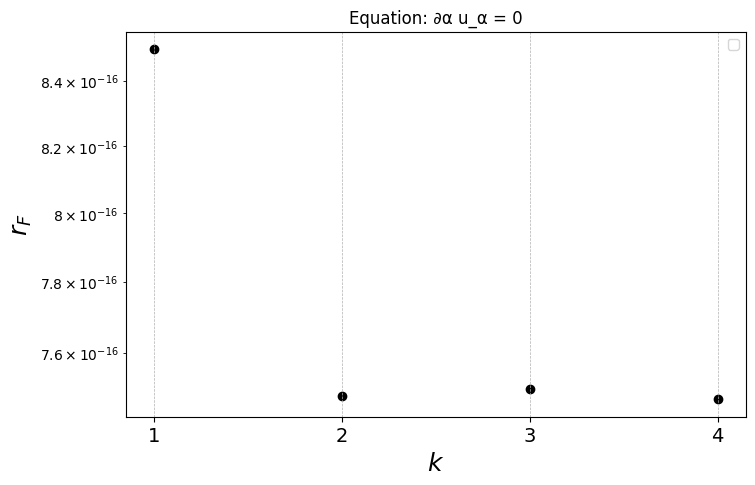

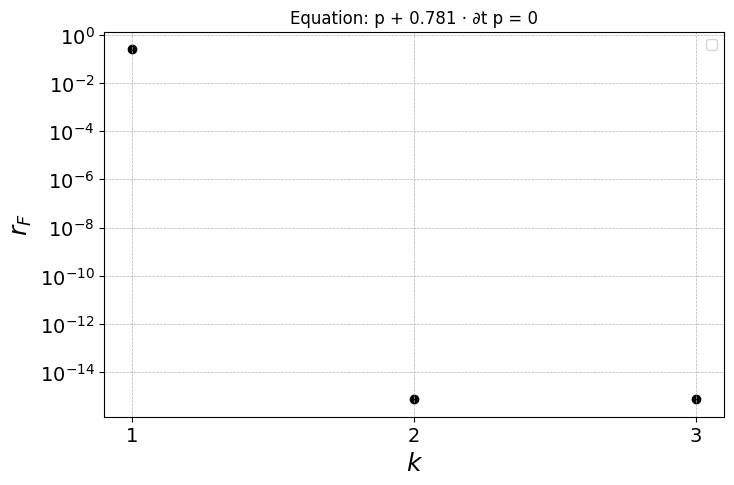

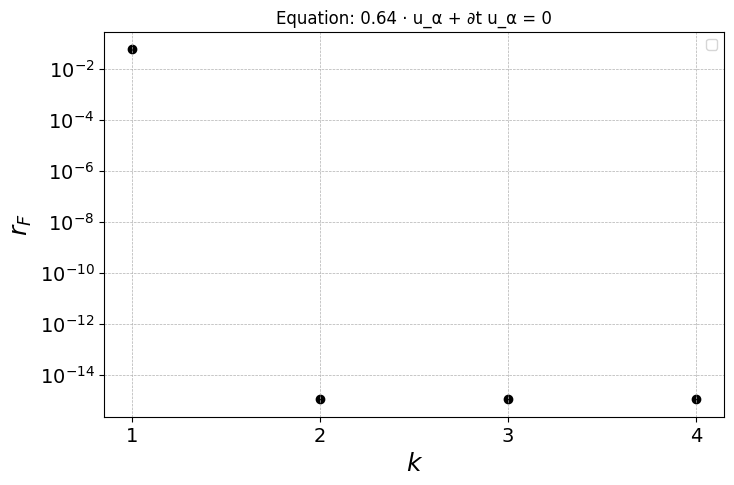

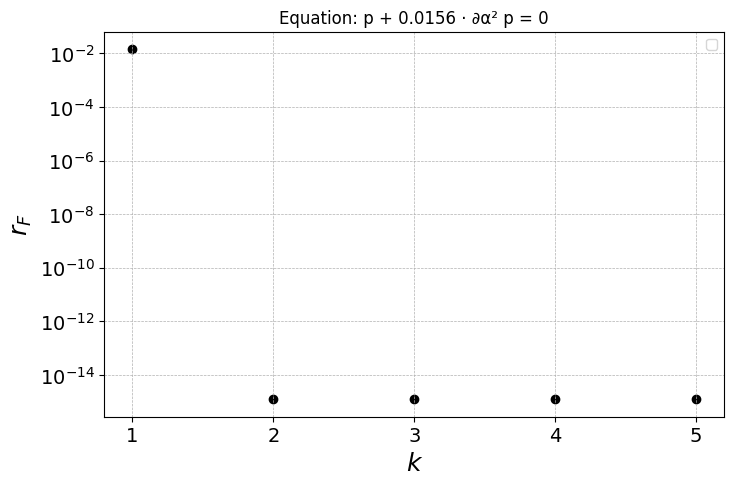

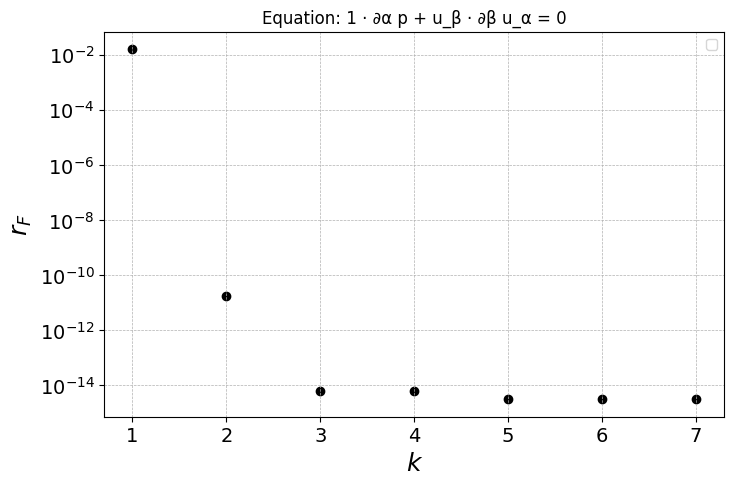

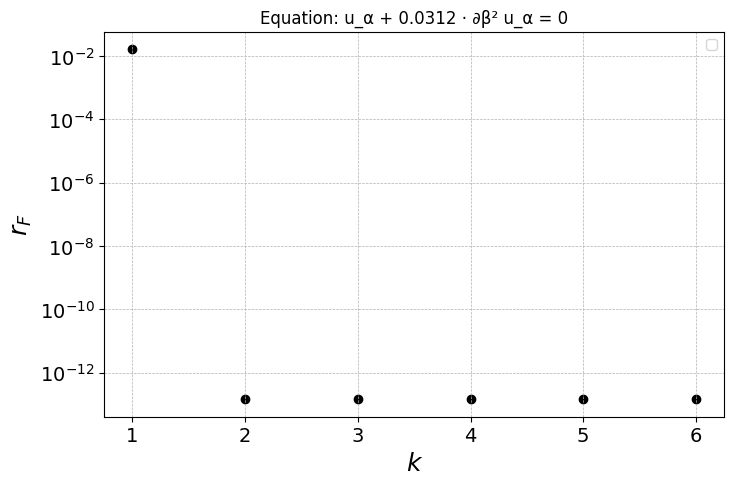

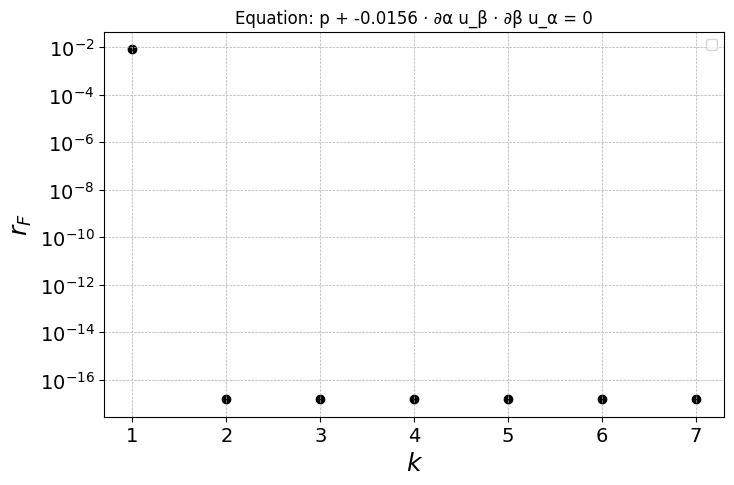

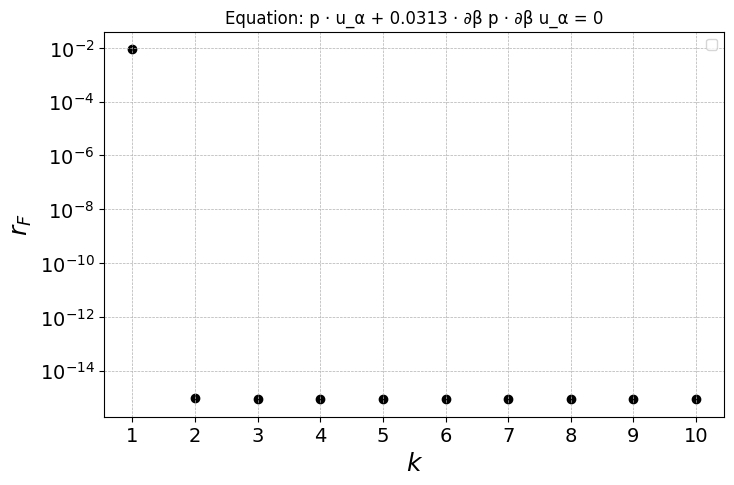

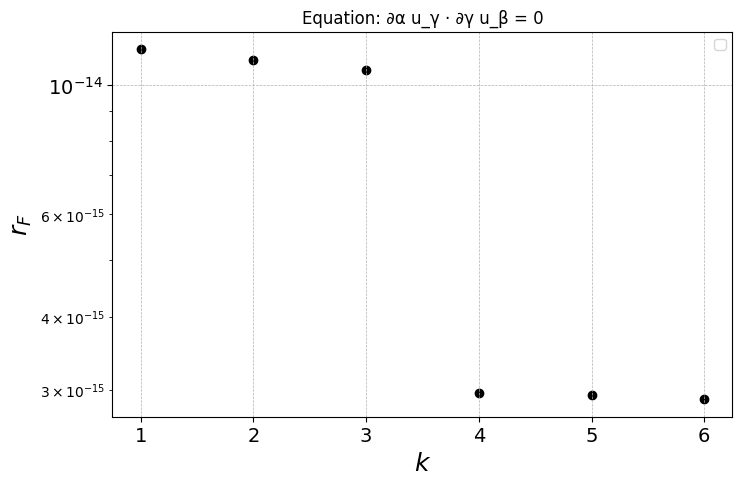

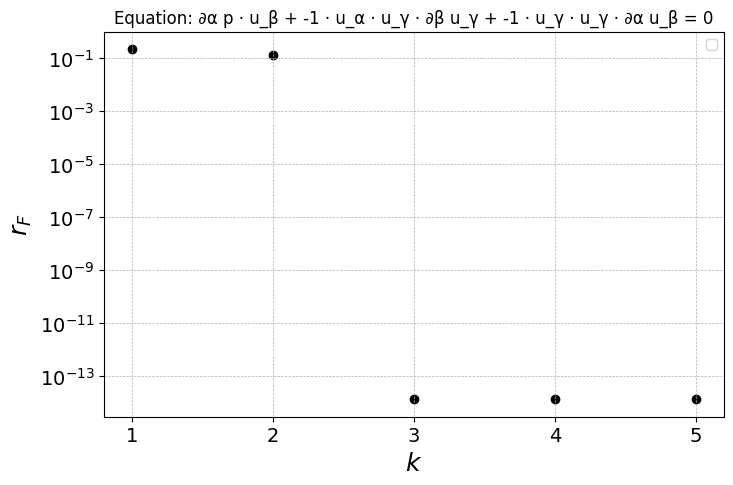

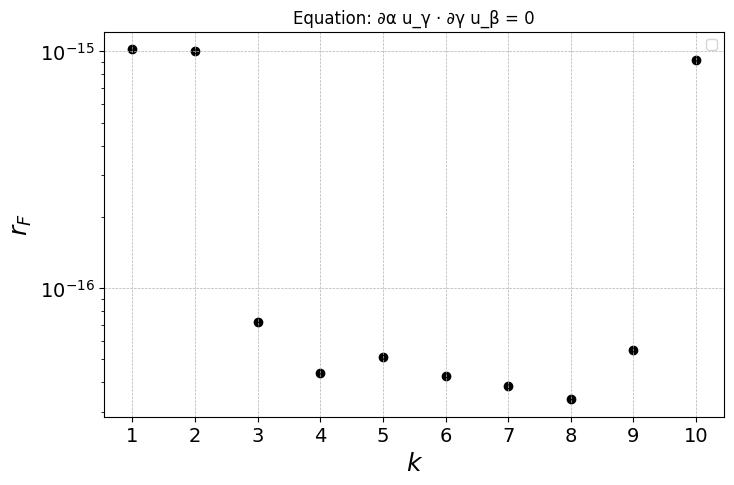

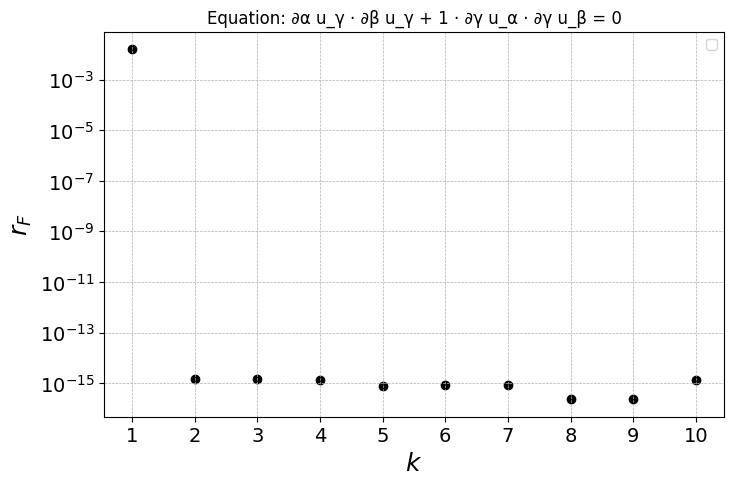

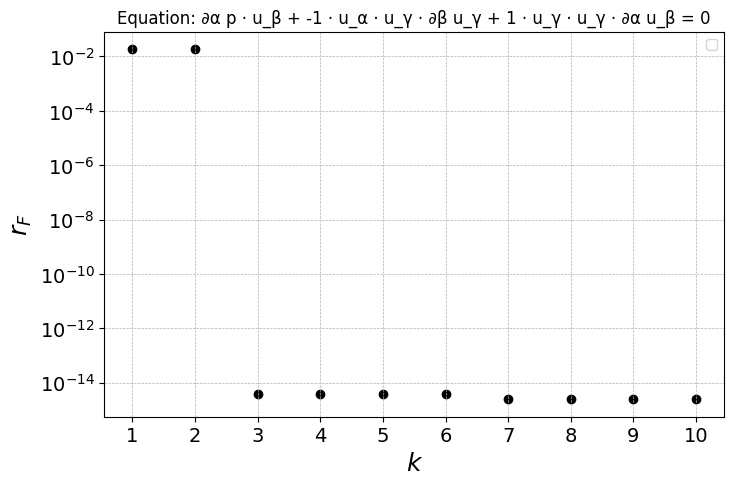

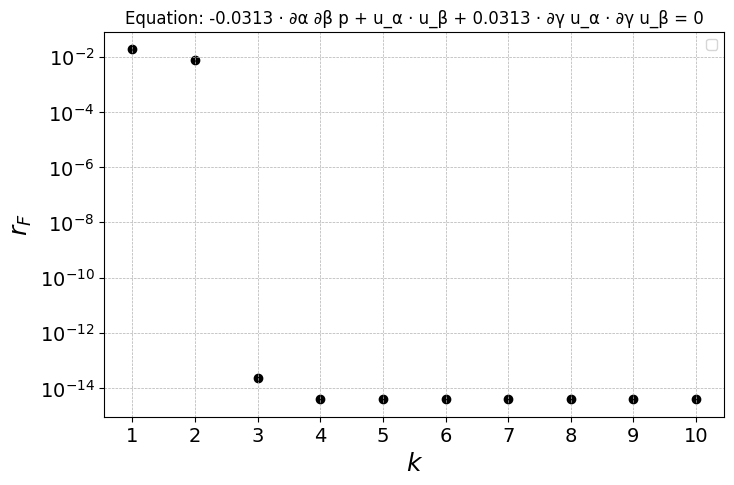

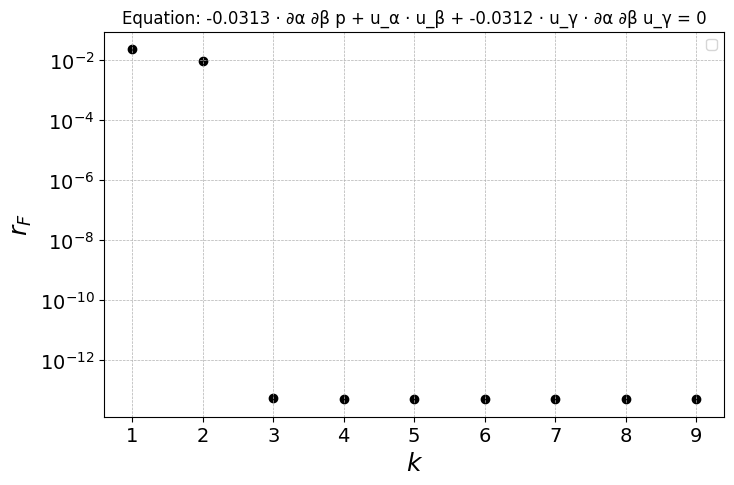

In [21]:
for i, res in enumerate(reg_results):
    all_lambdas = res.all_lambdas
    all_lambdas[0] = res.lambda1
    all_xis = res.all_xis
    xi_values = res.xi
    sublibrary_terms = res.sublibrary
    equations = []

    equation_string = str(eqs[i].pstr(**{'num_format': '{0:.3g}', 'latex_output': False}))
    
    plt.figure(figsize=(8, 5))
    plt.scatter(range(1, len(all_lambdas) + 1), all_lambdas, color='k')
    plt.yscale("log")

    fs = 18
    fs2 = 14
    plt.xlabel("$k$", fontsize=fs)
    plt.ylabel("$r_F$", fontsize=fs)
    plt.title(f"Equation: {equation_string}")
    plt.xticks(range(1, len(all_lambdas) + 1), fontsize=fs2)
    plt.yticks(fontsize=fs2)
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5)
    
    plt.show()